In [1]:
import pygad as pg
import numpy as np
import random
import time


In [2]:
def get_inputs(inputs_file):
    result = {}
    with open(inputs_file) as inputs:
        nr = 1
        for line in inputs:
            line = line[:-1].split(";")
            result[nr] = [int(number) for number in line]
            nr += 1
    return result


In [3]:
small_inputs = get_inputs("small_inputs.txt")
medium_inputs = get_inputs("medium_inputs.txt")
big_inputs = get_inputs("big_inputs.txt")


In [4]:
def get_result(solution):
    res = []
    for i in range(len(solution)):
        if solution[i] == 1:
            res.append(set[i])
    return res


def fitness_func(solution, solution_idx):
    if np.count_nonzero(np.array(solution) == 1) == 0:
        return -np.Inf
    else:
        res = np.sum(np.multiply(set, solution))
        return -abs(res)


set = [-7, -3, -2, 9000, 5, 8]
solution = [0, 1, 1, 0, 1, 0]

fitness = fitness_func(solution, 0)

result = get_result(solution)
print(result, fitness)


[-3, -2, 5] 0


In [5]:
gene_space = [0, 1]
num_genes = len(set)

sol_per_pop = 200
num_parents_mating = 100
num_generations = 500
keep_parents = 50

parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
mutation_num_genes = 1
stop_criteria = "reach_0"


In [6]:
def check_performance(inputs):
    def fitness_func(solution, solution_idx):
        if np.count_nonzero(np.array(solution) == 1) == 0:
            return -np.Inf
        else:
            res = np.sum(np.multiply(set, solution))
            return -abs(res)

    results = {
        "time": 0, "avg_time": 0,
        "good_solutions": 0, "good_solutions_percent": 0
    }

    for _ in range(100):
        set = inputs[random.randint(1, 5)]

        start = time.time()

        ga_instance = pg.GA(
            gene_space=gene_space,
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=fitness_func,
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            parent_selection_type=parent_selection_type,
            keep_parents=keep_parents,
            crossover_type=crossover_type,
            mutation_type=mutation_type,
            mutation_num_genes=mutation_num_genes,
            stop_criteria=stop_criteria
        )

        ga_instance.run()

        end = time.time()

        _, fitness, _ = ga_instance.best_solution()
        if fitness == 0:
            results["time"] += end - start
            results["good_solutions"] += 1

    results["avg_time"] = results["time"] / results["good_solutions"]
    results["good_solutions_percent"] = results["good_solutions"] / 100

    return results


In [ ]:
num_genes = 100
sol_per_pop = 20
num_parents_mating = 10
num_generations = 100
keep_parents = 6


In [ ]:
small_inputs_results = check_performance(small_inputs)
print(small_inputs_results)


In [ ]:
num_genes = 1000
sol_per_pop = 100
num_parents_mating = 50
num_generations = 300
keep_parents = 30


In [ ]:
medium_inputs_results = check_performance(medium_inputs)
print(medium_inputs_results)


In [7]:
num_genes = 5000
sol_per_pop = 200
num_parents_mating = 100
num_generations = 500
keep_parents = 50


In [8]:
big_inputs_results = check_performance(big_inputs)
print(big_inputs_results)


KeyboardInterrupt: 

In [9]:
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.discrete.binary import BinaryPSO
import matplotlib.pyplot as plt


In [10]:
def fitness_func(solution):
    if np.count_nonzero(np.array(solution) == 1) == 0:
        return np.Inf
    else:
        res = np.sum(np.multiply(set, solution))
        return abs(res)


def optimizer_function(x):
    n_particles = x.shape[0]
    j = [fitness_func(x[i]) for i in range(n_particles)]
    return np.array(j)


In [11]:
set = big_inputs[1]


In [12]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 1}


Best endurance: -3.0
Parameters of the best solution: [0 1 1 ... 0 0 0]


<Axes: title={'center': 'Cost History'}, xlabel='Iterations', ylabel='Cost'>

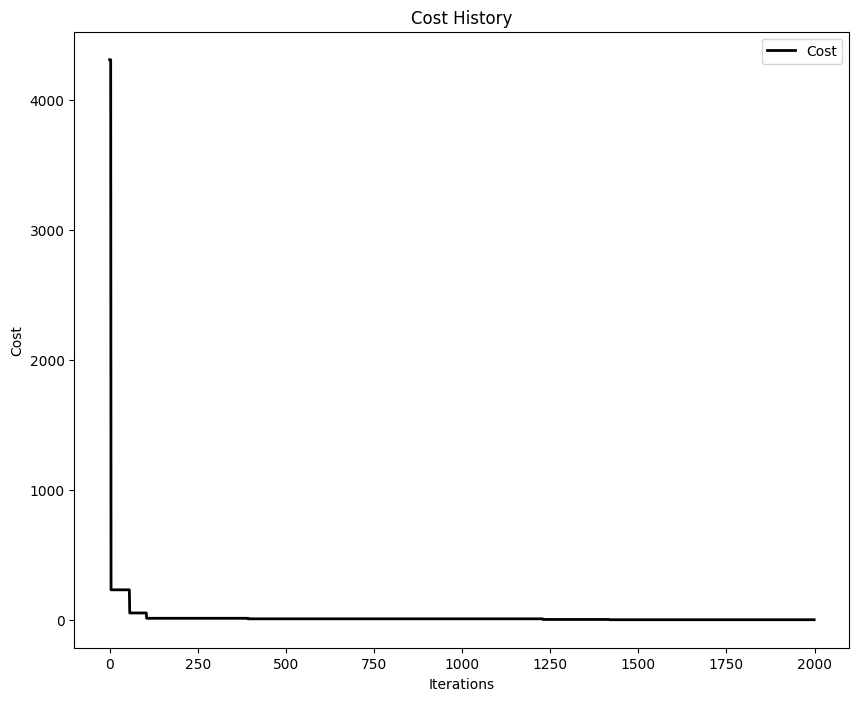

In [13]:
optimizer = BinaryPSO(
    n_particles=40, dimensions=len(set), options=options)

cost, pos = optimizer.optimize(optimizer_function, iters=2000, verbose=False)

print("Best endurance: {}".format(-cost))
print("Parameters of the best solution: {}".format(pos))
plot_cost_history(optimizer.cost_history)


In [ ]:
x = [str(random.randint(-5000, 5000)) for _ in range(5000)]

print(";".join(x))
